# Ch `05`: Concept `01`

## Clustering

We're going to need a Python library called the BregmanToolkit. It's available here: https://github.com/BinRoot/BregmanToolkit

One way to install it is by downloading from the GitHub link above, and then running `sudo python setup.py install` in the downloaded directory. You will also need scipy: `sudo pip2 install scipy`. Unfortunately, this BregmanToolkit library isn't supported on Python 3, so you'll have to use Python 2.


In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from bregman.suite import *

Define some hyper-parameters for clustering:

In [2]:
k = 2
max_iterations = 100

Select the location for the audio files:

In [3]:
filenames = tf.train.match_filenames_once('./audio_dataset/*.wav')
count_num_files = tf.size(filenames)
filename_queue = tf.train.string_input_producer(filenames)
reader = tf.WholeFileReader()
filename, file_contents = reader.read(filename_queue)

chromo = tf.placeholder(tf.float32)
max_freqs = tf.argmax(chromo, 0)

Create a helper function to get the next audio file's Chromogram:

In [4]:
def get_next_chromogram(sess):
    audio_file = sess.run(filename)
    print('Loading {}'.format(audio_file))
    F = Chromagram(audio_file, nfft=16384, wfft=8192, nhop=2205)
    return F.X, audio_file

And create a helper function to extract a feature vector from the Chromogram data:

In [5]:
def extract_feature_vector(sess, chromo_data):
    num_features, num_samples = np.shape(chromo_data)
    freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
    hist, bins = np.histogram(freq_vals, bins=range(num_features + 1))
    normalized_hist = hist.astype(float) / num_samples
    return normalized_hist

Extract a dataset of feature vectors by calling our helper functions above:

In [6]:
def get_dataset(sess):
    num_files = sess.run(count_num_files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    xs = list()
    names = list()
    
    for _ in range(num_files):
        plt.figure()
        chromo_data, filename = get_next_chromogram(sess)

        plt.subplot(1, 2, 1)
        plt.imshow(chromo_data, cmap='Greys', interpolation='nearest')
        plt.title('Visualization of Sound Spectrum')

        plt.subplot(1, 2, 2)
        freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
        plt.hist(freq_vals)
        plt.title('Histogram of Notes')
        plt.xlabel('Musical Note')
        plt.ylabel('Count')
        plt.savefig('{}.png'.format(filename))
        plt.show()

        names.append(filename)
        x = extract_feature_vector(sess, chromo_data)
        xs.append(x)
    xs = np.asmatrix(xs)
    coord.request_stop()
    coord.join(threads)
    return xs, names

k-means clustering requires 2 main phases: clustering and assignment. We'll also throw in an initialization helper function for good measure. Here are the three components:


In [7]:
def initial_cluster_centroids(X, k):
    return X[0:k, :]


def assign_cluster(X, centroids):
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    return mins


def recompute_centroids(X, Y):
    sums = tf.unsorted_segment_sum(X, Y, k)
    counts = tf.unsorted_segment_sum(tf.ones_like(X), Y, k)
    return sums / counts


Open a session, obtain a dataset, and cluster the data:

Loading ./audio_dataset/cough_1.wav


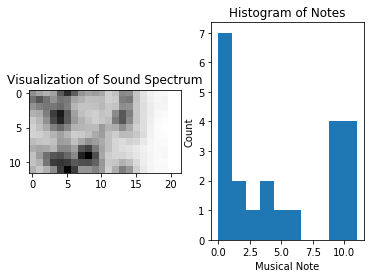

Loading ./audio_dataset/scream_1.wav


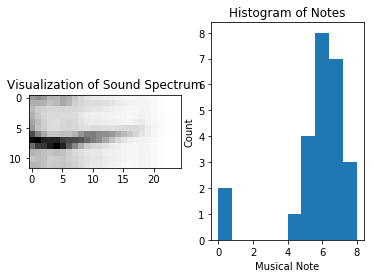

Loading ./audio_dataset/scream_2.wav


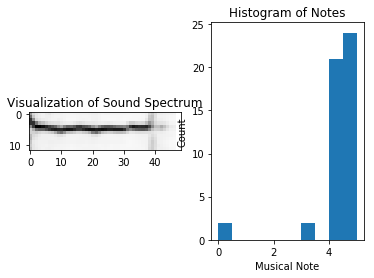

Loading ./audio_dataset/scream_3.wav


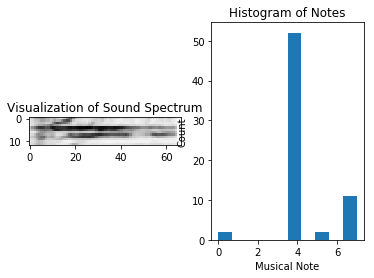

Loading ./audio_dataset/cough_2.wav


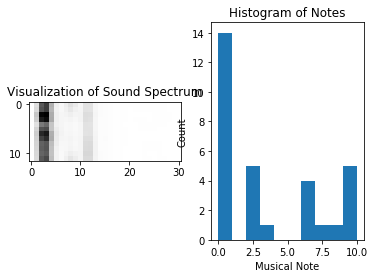

[(0, './audio_dataset/cough_1.wav'), (1, './audio_dataset/scream_1.wav'), (0, './audio_dataset/scream_2.wav'), (0, './audio_dataset/scream_3.wav'), (0, './audio_dataset/cough_2.wav')]


In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #sess.run(tf.local_variables_initializer())
    X, names = get_dataset(sess)
    centroids = initial_cluster_centroids(X, k)
    i, converged = 0, False
    while not converged and i < max_iterations:
        i += 1
        Y = assign_cluster(X, centroids)
        centroids = sess.run(recompute_centroids(X, Y))
    print(zip(sess.run(Y), names))
